In [72]:
import numpy as np
import pandas as pd
import random
import math
from firebase_admin import firestore
import firebase_admin
from firebase_admin import firestore, credentials
import matplotlib.pyplot as plt

In [73]:
###>>>>>>>>>>>>>>>>>>>>>>>>>> Initialize Firebase client
try:
    app = firebase_admin.get_app()
except ValueError as e:
    cred = credentials.Certificate("C:/Users/leemn/OneDrive/Documents/Service Account/accountkey_firebase.json")
    firebase_admin.initialize_app(cred)
db = firestore.client() 

In [74]:
df = pd.read_excel(r'C:/Users/leemn/OneDrive/Documents/Route Planning/Takealot_CTD_Data.xlsx',
                   sheet_name='CTD_27_Feb')
df.head()

,waybillid,driverid,Delivery,Timestamp,Delivery_lat,Delivery_lon,Origin_Hub,Origin_Lat,Origin_Long
0,96766835.0,32631.0,2023-02-27,08:03:01.992,-33.966939,18.500546,CTD,-33.862592,18.521128
1,96762597.0,32631.0,2023-02-27,08:11:50.528,-33.978897,18.506432,CTD,-33.862592,18.521128
2,96693569.0,32631.0,2023-02-27,08:55:31.821,-33.998144,18.509564,CTD,-33.862592,18.521128
3,96733983.0,32631.0,2023-02-27,09:10:54.647,-34.014890,18.483872,CTD,-33.862592,18.521128
4,96804265.0,32631.0,2023-02-27,09:27:13.333,-33.998820,18.474928,CTD,-33.862592,18.521128


In [75]:
data = df.rename(columns={'Delivery_lat':'latitude','Delivery_lon':'longitude'})
data = data.head(7)

In [76]:
#locations = data[['latitude', 'longitude']].values.tolist()

### Get_Optimal_Route.py

In [64]:
import numpy as np
import random
import math
from firebase_admin import firestore
import firebase_admin
from firebase_admin import firestore, credentials
import requests

def optimize_route(nodes):
    order_count = len(nodes)
    restart_iteration = 100

    route_distances_matrix = fetch_distance_matrix_offline(nodes)

    if order_count <= 2:
        print('only 1 order in node')
        return {'route_plan': [0, 1, 2], 'route_distance': 1.1}

    if order_count < 11:
        restart_iteration = 100
    elif 11 <= order_count <= 20:
        restart_iteration = 150
    elif 21 <= order_count <= 40:
        restart_iteration = 200
    elif 41 <= order_count <= 80:
        restart_iteration = 200
    else:
        restart_iteration = 200

    temp_start = 1e+10
    temp_end = 0.000001
    cooling_fact = 0.99
    # Firt random route selection (Using index range from 0 to nrows)
    random_generator = np.random.permutation(range(1, len(route_distances_matrix)))
    route_best = np.array(random_generator).tolist()
    route_best.insert(0, 0)
    route_best.append(0)
    distance_best = total_distance(route_best, route_distances_matrix)
    try:
        for restart in range(restart_iteration):
            # restart variables from best known solution (Efficiency update)
            temp = temp_start
            route_current = route_best[:]
            route_new = route_current[:]
            distance_current = distance_best
            distance_new = distance_current
            while temp > temp_end:
                swap_index = random.sample(range(1, len(route_distances_matrix)), 2)
                route_new[swap_index[0]], route_new[swap_index[1]] = route_current[swap_index[1]], route_current[
                    swap_index[0]]
                distance_new = swap_distance(distance_current, route_current, route_distances_matrix, swap_index)
                diff = distance_new - distance_current
                if diff < 0 or math.exp(-diff / temp) > random.random():
                    route_current = route_new[:]
                    distance_current = distance_new
                else:
                    route_new = route_current[:]
                    distance_new = distance_current
                if distance_new < distance_best:
                    route_best = route_new[:]
                    distance_best = distance_new
                temp = temp * cooling_fact

        route = []
        for best in range(0, len(route_best)):
            route.append(route_distances_matrix[route_best[best]])

        return {'route_plan': route_best, 'route_distance': distance_best}

    except KeyboardInterrupt:
        print('Code execution cancelled')

def fetch_distance_matrix_offline(locations):
    amount_of_locations = locations[:]
    distance_matrix = [[] for loc in range(len(amount_of_locations))]

    for index, base_location in enumerate(locations):
        # split_lat_lon = base_location.split(',')
        base_lat = float(base_location.latitude) * 0.01745329251
        base_lon = float(base_location.longitude) * 0.01745329251

        for destination in locations:
            # split_destination_lat_lon = destination.split(',')
            destination_lat = float(destination.latitude) * 0.01745329251
            destination_lon = float(destination.longitude) * 0.01745329251

            distance_between = np.arccos(
                np.sin(base_lat) * np.sin(destination_lat) + np.cos(base_lat) * np.cos(
                    destination_lat) * np.cos(destination_lon - base_lon)) * 6371

            distance_matrix[index].append(distance_between)

    return distance_matrix

def total_distance(route, route_distance):
    total_distance = 0
    for i in range(0, len(route) - 1):
        total_distance = total_distance + route_distance[route[i]][route[i + 1]]
    return total_distance


def swap_distance(distance_current, route_current, route_distance, swap_index):
    min_index = min(swap_index[0], swap_index[1])
    max_index = max(swap_index[0], swap_index[1])

    if min_index == max_index - 1:
        before_swap = route_distance[route_current[min_index - 1]][route_current[min_index]] + \
                      route_distance[route_current[min_index]][route_current[max_index]] + \
                      route_distance[route_current[max_index]][route_current[max_index + 1]]
        after_swap = route_distance[route_current[min_index - 1]][route_current[max_index]] + \
                     route_distance[route_current[max_index]][route_current[min_index]] + \
                     route_distance[route_current[min_index]][route_current[max_index + 1]]

    else:
        before_swap = route_distance[route_current[min_index - 1]][route_current[min_index]] + \
                      route_distance[route_current[min_index]][route_current[min_index + 1]] + \
                      route_distance[route_current[max_index - 1]][route_current[max_index]] + \
                      route_distance[route_current[max_index]][route_current[max_index + 1]]
        after_swap = route_distance[route_current[min_index - 1]][route_current[max_index]] + \
                     route_distance[route_current[max_index]][route_current[min_index + 1]] + \
                     route_distance[route_current[max_index - 1]][route_current[min_index]] + \
                     route_distance[route_current[min_index]][route_current[max_index + 1]]

    distance_new = distance_current - before_swap + after_swap

    return distance_new

## Test

In [90]:
import numpy as np
import random
import math
import pandas as pd

def optimize_route(data):
    nodes = data[['latitude', 'longitude']].to_numpy()
    order_count = len(nodes)
    restart_iteration = 100

    route_distances_matrix = fetch_distance_matrix(nodes)

    if order_count <= 2:
        print('only 1 order in node')
        return {'route_plan': [0, 1, 2], 'route_distance': 1.1}

    if order_count < 11:
        restart_iteration = 100
    elif 11 <= order_count <= 20:
        restart_iteration = 150
    elif 21 <= order_count <= 40:
        restart_iteration = 200
    elif 41 <= order_count <= 80:
        restart_iteration = 200
    else:
        restart_iteration = 200

    temp_start = 1e+10
    temp_end = 0.000001
    cooling_fact = 0.99
    # Firt random route selection (Using index range from 0 to nrows)
    random_generator = np.random.permutation(range(1, len(route_distances_matrix)))
    route_best = np.array(random_generator).tolist()
    route_best.insert(0, 0)
    route_best.append(0)
    distance_best = total_distance(route_best, route_distances_matrix)
    try:
        routes = {tuple(route_best): distance_best}  # dictionary to store all the generated routes and their distances
        for restart in range(restart_iteration):
            # restart variables from best known solution (Efficiency update)
            temp = temp_start
            route_current = route_best[:]
            route_new = route_current[:]
            distance_current = distance_best
            distance_new = distance_current
            while temp > temp_end:
                swap_index = random.sample(range(1, len(route_distances_matrix)), 2)
                route_new[swap_index[0]], route_new[swap_index[1]] = route_current[swap_index[1]], route_current[
                    swap_index[0]]
                distance_new = swap_distance(distance_current, route_current, route_distances_matrix, swap_index)
                diff = distance_new - distance_current
                if diff < 0 or math.exp(-diff / temp) > random.random():
                    route_current = route_new[:]
                    distance_current = distance_new
                else:
                    route_new = route_current[:]
                    distance_new = distance_current
                if distance_new < distance_best:
                    route_best = route_new[:]
                    distance_best = distance_new
                    routes[tuple(route_best)] = distance_best  # update the dictionary with the new best route and its distance
                temp = temp * cooling_fact

        # sort the dictionary by distance and print all the routes
        sorted_routes = sorted(routes.items(), key=lambda x: x[1])
        for i, (route, distance) in enumerate(sorted_routes):
            print(f"Route {i+1}: {' -> '.join(str(n) for n in route)} - Distance: {distance}")

        route_best.pop()        
        data = data.assign(route_best=route_best, distance_best=distance_best)
        
        print({'route_plan': route_best, 'route_distance': distance_best})
        return data

    except KeyboardInterrupt:
        print('Code execution cancelled')

def fetch_distance_matrix(nodes):
    amount_of_locations = nodes[:]
    distance_matrix = [[] for loc in range(len(amount_of_locations))]

    for index, base_location in enumerate(nodes):
        base_lat = float(base_location[0]) * 0.01745329251
        base_lon = float(base_location[1]) * 0.01745329251

        for destination in nodes:
            destination_lat = float(destination[0]) * 0.01745329251
            destination_lon = float(destination[1]) * 0.01745329251

            distance_between = np.arccos(
                np.sin(base_lat) * np.sin(destination_lat) + np.cos(base_lat) * np.cos(
                    destination_lat) * np.cos(destination_lon - base_lon)) * 6371

            distance_matrix[index].append(distance_between)

    return distance_matrix

def total_distance(route, route_distance):
    total_distance = 0
    for i in range(0, len(route) - 1):
        total_distance = total_distance + route_distance[route[i]][route[i + 1]]
    return total_distance


def swap_distance(distance_current, route_current, route_distance, swap_index):
    min_index = min(swap_index[0], swap_index[1])
    max_index = max(swap_index[0], swap_index[1])

    if min_index == max_index - 1:
        before_swap = route_distance[route_current[min_index - 1]][route_current[min_index]] + \
                      route_distance[route_current[min_index]][route_current[max_index]] + \
                      route_distance[route_current[max_index]][route_current[max_index + 1]]
        after_swap = route_distance[route_current[min_index - 1]][route_current[max_index]] + \
                     route_distance[route_current[max_index]][route_current[min_index]] + \
                     route_distance[route_current[min_index]][route_current[max_index + 1]]

    else:
        before_swap = route_distance[route_current[min_index - 1]][route_current[min_index]] + \
                      route_distance[route_current[min_index]][route_current[min_index + 1]] + \
                      route_distance[route_current[max_index - 1]][route_current[max_index]] + \
                      route_distance[route_current[max_index]][route_current[max_index + 1]]
        after_swap = route_distance[route_current[min_index - 1]][route_current[max_index]] + \
                     route_distance[route_current[max_index]][route_current[min_index + 1]] + \
                     route_distance[route_current[max_index - 1]][route_current[min_index]] + \
                     route_distance[route_current[min_index]][route_current[max_index + 1]]

    distance_new = distance_current - before_swap + after_swap

    return distance_new

In [91]:
data = optimize_route(data)
data.head()

Route 1: 0 -> 6 -> 5 -> 4 -> 3 -> 2 -> 1 -> 0 - Distance: 13.656917861570587
Route 2: 0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 0 - Distance: 13.656917861570612
Route 3: 0 -> 6 -> 4 -> 5 -> 3 -> 2 -> 1 -> 0 - Distance: 14.187918687007842
Route 4: 0 -> 1 -> 2 -> 3 -> 4 -> 6 -> 5 -> 0 - Distance: 14.869603894730696
Route 5: 0 -> 1 -> 6 -> 5 -> 4 -> 3 -> 2 -> 0 - Distance: 14.939156469930536
Route 6: 0 -> 2 -> 3 -> 5 -> 4 -> 6 -> 1 -> 0 - Distance: 15.470157295363064
Route 7: 0 -> 2 -> 5 -> 3 -> 4 -> 6 -> 1 -> 0 - Distance: 16.58545012732552
Route 8: 0 -> 2 -> 5 -> 1 -> 4 -> 6 -> 3 -> 0 - Distance: 23.398523721809834
{'route_plan': [0, 6, 5, 4, 3, 2, 1], 'route_distance': 13.656917861570587}


,waybillid,driverid,Delivery,Timestamp,latitude,longitude,Origin_Hub,Origin_Lat,Origin_Long,route_best,distance_best
0,96766835.0,32631.0,2023-02-27,08:03:01.992,-33.966939,18.500546,CTD,-33.862592,18.521128,0,13.656918
1,96762597.0,32631.0,2023-02-27,08:11:50.528,-33.978897,18.506432,CTD,-33.862592,18.521128,6,13.656918
2,96693569.0,32631.0,2023-02-27,08:55:31.821,-33.998144,18.509564,CTD,-33.862592,18.521128,5,13.656918
3,96733983.0,32631.0,2023-02-27,09:10:54.647,-34.014890,18.483872,CTD,-33.862592,18.521128,4,13.656918
4,96804265.0,32631.0,2023-02-27,09:27:13.333,-33.998820,18.474928,CTD,-33.862592,18.521128,3,13.656918


The possible routes above are not all the possible routes in the search space that the code could explore (n-1)!, this is just the subset of the routes explored. This is because it is limited by the restart_iteration variable. This variable controls the number of times the algorithm restarts from a random route to find a better one.

The constraints limit the number of iterations based on the number of orders, so for a larger number of orders, the algorithm will take longer to run. This means that the algorithm will not explore all possible routes, but rather a subset of them. Hence we only seeing very few possible routes.

Distance: 13.656917861569806


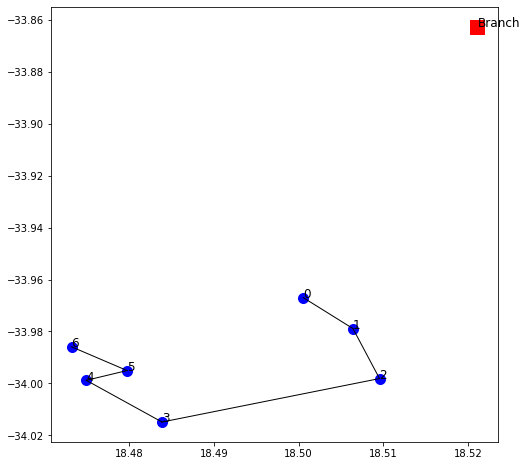

In [79]:
# add branch point
depot_lat = -33.86259
depot_lon = 18.52113

# sort dataframe by sequence
data = data.sort_values('route_best')

# plot points and labels
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(data['longitude'], data['latitude'], s=100, color='blue')
for i, row in data.iterrows():
    ax.annotate(row['route_best'], (row['longitude'], row['latitude']), fontsize=12)

# plot lines connecting points
for i in range(len(data)-1):
    start = (data.iloc[i]['longitude'], data.iloc[i]['latitude'])
    end = (data.iloc[i+1]['longitude'], data.iloc[i+1]['latitude'])
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=1)

# plot Branch point
ax.scatter(depot_lon, depot_lat, s=200, color='red', marker='s')
ax.annotate('Branch', (depot_lon, depot_lat), fontsize=12)
print(f'Distance: {data.distance_best.max()}')
plt.show()

## Nearest Neibhor

In [80]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the Haversine distance between two points on the Earth's surface
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    km = 6367 * c
    return km

def nearest_neighbor(df, max_iterations=2000):
    # Initialize the route with the depot as the starting point
    depot_coord = [df.loc[0, 'Origin_Lat'], df.loc[0, 'Origin_Long']]
    route = [df.index[0]]
    unvisited = np.ones(len(df), dtype=bool)
    unvisited[0] = False

    # Loop through unvisited orders and add them to the route in the nearest order
    num_iterations = 0
    while unvisited.sum() > 0 and num_iterations < max_iterations:
        # Get the coordinates of the last visited order
        last_order_coord = df.loc[route[-1], ['latitude', 'longitude']].astype(float).values

        # Get all unvisited orders with the same coordinates
        same_coord_orders = df.loc[unvisited & (df[['latitude', 'longitude']].astype(float).values == last_order_coord).all(axis=1)]

        # If there are any unvisited orders with the same coordinates, group them first
        if len(same_coord_orders) > 0:
            route += list(same_coord_orders.index)
            unvisited[same_coord_orders.index] = False

        # Otherwise, add the nearest unvisited order to the route
        else:
            distances = [haversine(df.loc[route[-1], 'longitude'], df.loc[route[-1], 'latitude'], 
                                   df.loc[i, 'longitude'], df.loc[i, 'latitude']) for i in df.index[unvisited]]
            nearest_index = np.argmin(distances)
            nearest_order = df.index[unvisited][nearest_index]
            route.append(nearest_order)
            unvisited[nearest_order] = False

        num_iterations += 1

    # Add 'Sequence' column to the dataframe
    df['Sequence'] = np.arange(len(df))+1

    # Calculate distances between consecutive orders in the optimized route
    distances = []
    for i in range(len(route)-1):
        start = df.loc[route[i], ['latitude', 'longitude']].astype(float)
        end = df.loc[route[i+1], ['latitude', 'longitude']].astype(float)
        distances.append(haversine(start[1], start[0], end[1], end[0]))

    # Add 'Distance' column to the dataframe
    df.loc[route[:-1], 'Distance'] = distances
    df.loc[route[-1], 'Distance'] = 0

    # Reorder the rows in the dataframe according to the optimized route
    df = df.loc[route]

    print(f'Number of iterations: {num_iterations}')

    return df

In [81]:
df2 = df.head(7)
df2 = df2.rename(columns={'Delivery_lat':'latitude','Delivery_lon':'longitude'})

In [82]:
optimized_df = nearest_neighbor(df2)
optimized_df.head(7)

Number of iterations: 6


,waybillid,driverid,Delivery,Timestamp,latitude,longitude,Origin_Hub,Origin_Lat,Origin_Long,Sequence,Distance
0,96766835.0,32631.0,2023-02-27,08:03:01.992,-33.966939,18.500546,CTD,-33.862592,18.521128,1,1.435199
1,96762597.0,32631.0,2023-02-27,08:11:50.528,-33.978897,18.506432,CTD,-33.862592,18.521128,2,2.158199
2,96693569.0,32631.0,2023-02-27,08:55:31.821,-33.998144,18.509564,CTD,-33.862592,18.521128,3,2.768420
5,96697278.0,32631.0,2023-02-27,09:38:56.959,-33.995059,18.479747,CTD,-33.862592,18.521128,6,0.609715
4,96804265.0,32631.0,2023-02-27,09:27:13.333,-33.998820,18.474928,CTD,-33.862592,18.521128,5,1.442365
6,96717258.0,32631.0,2023-02-27,09:47:54.389,-33.985920,18.473197,CTD,-33.862592,18.521128,7,3.366160
3,96733983.0,32631.0,2023-02-27,09:10:54.647,-34.014890,18.483872,CTD,-33.862592,18.521128,4,0.000000


Distance: 11.78005656967384


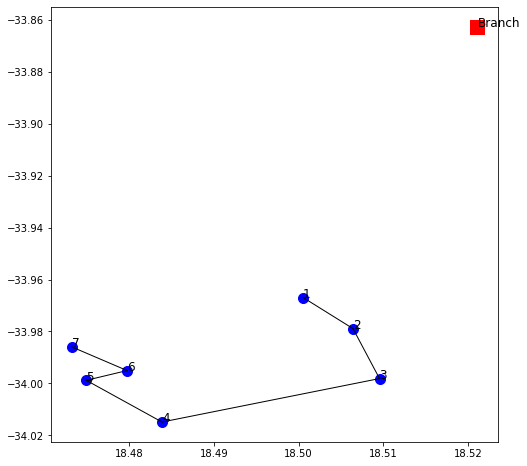

In [83]:
# add branch point
depot_lat = -33.86259
depot_lon = 18.52113

# sort dataframe by sequence
optimized_df = optimized_df.sort_values('Sequence')

# plot points and labels
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(optimized_df['longitude'], optimized_df['latitude'], s=100, color='blue')
for i, row in optimized_df.iterrows():
    ax.annotate(row['Sequence'], (row['longitude'], row['latitude']), fontsize=12)

# plot lines connecting points
for i in range(len(optimized_df)-1):
    start = (optimized_df.iloc[i]['longitude'], optimized_df.iloc[i]['latitude'])
    end = (optimized_df.iloc[i+1]['longitude'], optimized_df.iloc[i+1]['latitude'])
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=1)

# plot Branch point
ax.scatter(depot_lon, depot_lat, s=200, color='red', marker='s')
ax.annotate('Branch', (depot_lon, depot_lat), fontsize=12)
print(f'Distance: {optimized_df.Distance.sum()}')

plt.show()

### Held-Karp

In [84]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.optimize import linear_sum_assignment
import itertools
import numpy as np
import pandas as pd
import math


def haversine(origin, destination):
    # haversine distance formula
    lat1, lon1 = origin
    lat2, lon2 = destination
    R = 6371  # earth radius in km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

def calculate_route(df):
    # extract delivery and depot locations
    delivery_locations = df[['latitude', 'longitude']].values
    depot_locations = df[['Origin_Lat', 'Origin_Long']].values

    # calculate pairwise distances between delivery locations and depot locations
    dist1 = pdist(delivery_locations, metric=haversine)
    dist2 = pdist(depot_locations, metric=haversine)

    # convert the pairwise distances into a square distance matrix
    dist_matrix1 = squareform(dist1)
    dist_matrix2 = squareform(dist2)

    # find the minimum spanning tree of the distance matrix
    mst1 = minimum_spanning_tree(csr_matrix(dist_matrix1))
    mst2 = minimum_spanning_tree(csr_matrix(dist_matrix2))

    # get the indices of the edges in the minimum spanning tree
    edge_indices1 = mst1.nonzero()
    edge_indices2 = mst2.nonzero()

    # create a list of all the addresses
    all_addresses = [(df.iloc[i]['latitude'], df.iloc[i]['longitude']) for i in range(len(df))]

    # create a list of all the depot addresses
    depot_addresses = [(df.iloc[i]['Origin_Lat'], df.iloc[i]['Origin_Long']) for i in range(len(df))]

    # create a list of all the addresses, including depots
    all_addresses_with_depots = depot_addresses + all_addresses

    # calculate the pairwise distances between all the addresses
    dist = pdist(all_addresses_with_depots, metric=haversine)

    # create the distance matrix
    dist_matrix = squareform(dist)

    # set the diagonal to infinity to prevent cycles
    np.fill_diagonal(dist_matrix, np.inf)

    # find the optimal route using the held-karp algorithm
    row_ind, col_ind = linear_sum_assignment(dist_matrix)

    # remove the depots from the optimal route
    indices_without_depots = [i for i in col_ind if i >= len(depot_addresses)]

    # calculate the optimal route and distance
    optimal_route = [all_addresses[i - len(depot_addresses)] for i in col_ind if i >= len(depot_addresses)]
    optimal_distance = dist_matrix[row_ind, col_ind].sum()

    # add the optimal route and distance to the dataframe
    route_seq = []
    distances = []
    current_lat = df.iloc[0]['Origin_Lat']
    current_long = df.iloc[0]['Origin_Long']
    for i in indices_without_depots:
        lat, long = all_addresses[i - len(depot_addresses)]
        distance = dist_matrix[i, col_ind[i]]
        route_seq.append(i - len(depot_addresses) + 1)
        distances.append(distance)
        current_lat = lat
        current_long = long
    df['Sequence_HK'] = route_seq
    df['Distance_HK'] = distances


    # create a list to store all routes and their distances
    # create a list to store all routes and their distances
    all_routes = []

    # add the optimal route and distance to the list of all routes
    optimal_route_str = 'Optimal Route'
    all_routes.append((optimal_route_str, optimal_route, optimal_distance))

    # create a list of all possible permutations of the indices without depots
    permutations = list(itertools.permutations(indices_without_depots))

    # calculate the routes and distances for all the permutations
    for i, perm in enumerate(permutations):
        route = [all_addresses[i - len(depot_addresses)] for i in perm]
        distance = 0
        current_lat = df.iloc[0]['Origin_Lat']
        current_long = df.iloc[0]['Origin_Long']

        # calculate the distance for each leg of the route
        for j in range(len(route)):
            lat, long = route[j]
            distance += haversine((current_lat, current_long), (lat, long))
            current_lat = lat
            current_long = long

        # add the distance from the last stop back to the depot
        distance += haversine((current_lat, current_long), (df.iloc[0]['Origin_Lat'], df.iloc[0]['Origin_Long']))

        # add the route and distance to the list of all routes
        route_str = ' -> '.join([str(loc).strip() for loc in route])
        all_routes.append((f"Route {i+1}: {route_str}", distance))

    # sort the list of all routes by distance in ascending order
    #all_routes.sort(key=operator.itemgetter(1))

    # print the optimal route and distance
    optimal_route_index = all_routes.index((optimal_route_str, optimal_route, optimal_distance))
    optimal_route_label = f"Optimal Route {optimal_route_index}"
    print(f"{optimal_route_label}: {optimal_route}")
    print(f"Optimal Distance: {optimal_distance}")

    # print all the routes and distances
    #print("All Routes:")
    #for i, route in enumerate(all_routes):
        #if i == optimal_route_index:
            #continue
        #print(f"{route[0]}")
        #print(f"Distance: {route[1]}")

    return df

In [85]:
df3 = df.head(7)
df3 = df3.rename(columns={'Delivery_lat':'latitude','Delivery_lon':'longitude'})

In [86]:
df_hk = calculate_route(df3)
df_hk.head(7)

Optimal Route 0: [(-33.9788967, 18.5064317), (-33.9669393, 18.5005463), (-34.01489, 18.4838717), (-33.9981436, 18.5095641), (-33.9950587, 18.4797465), (-33.98592, 18.4731967), (-33.99882, 18.4749283)]
Optimal Distance: 12.132959287332367


,waybillid,driverid,Delivery,Timestamp,latitude,longitude,Origin_Hub,Origin_Lat,Origin_Long,Sequence_HK,Distance_HK
0,96766835.0,32631.0,2023-02-27,08:03:01.992,-33.966939,18.500546,CTD,-33.862592,18.521128,2,1.436100
1,96762597.0,32631.0,2023-02-27,08:11:50.528,-33.978897,18.506432,CTD,-33.862592,18.521128,1,1.436100
2,96693569.0,32631.0,2023-02-27,08:55:31.821,-33.998144,18.509564,CTD,-33.862592,18.521128,4,3.012666
3,96733983.0,32631.0,2023-02-27,09:10:54.647,-34.014890,18.483872,CTD,-33.862592,18.521128,3,3.012666
4,96804265.0,32631.0,2023-02-27,09:27:13.333,-33.998820,18.474928,CTD,-33.862592,18.521128,6,1.182058
5,96697278.0,32631.0,2023-02-27,09:38:56.959,-33.995059,18.479747,CTD,-33.862592,18.521128,7,1.443271
6,96717258.0,32631.0,2023-02-27,09:47:54.389,-33.985920,18.473197,CTD,-33.862592,18.521128,5,0.610098


Distance: 12.132959287332367


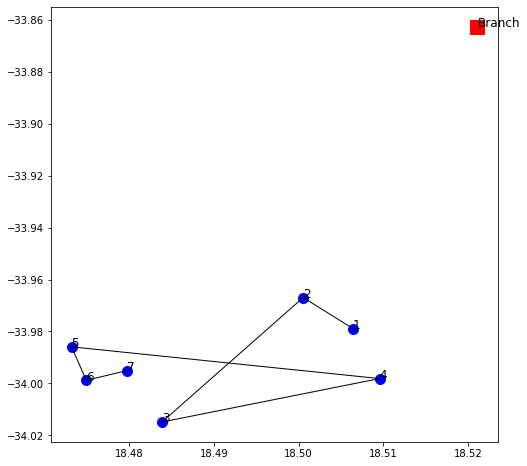

In [87]:
# add branch point
depot_lat = -33.86259
depot_lon = 18.52113

# sort dataframe by sequence
df_hk = df_hk.sort_values('Sequence_HK')

# plot points and labels
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(df_hk['longitude'], df_hk['latitude'], s=100, color='blue')
for i, row in df_hk.iterrows():
    ax.annotate(row['Sequence_HK'], (row['longitude'], row['latitude']), fontsize=12)

# plot lines connecting points
for i in range(len(df_hk)-1):
    start = (df_hk.iloc[i]['longitude'], df_hk.iloc[i]['latitude'])
    end = (df_hk.iloc[i+1]['longitude'], df_hk.iloc[i+1]['latitude'])
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=1)

# plot Branch point
ax.scatter(depot_lon, depot_lat, s=200, color='red', marker='s')
ax.annotate('Branch', (depot_lon, depot_lat), fontsize=12)
print(f'Distance: {df_hk.Distance_HK.sum()}')
plt.show()